# Proyecto 1: ONU ODS

- Juan Camilo Colmenares - 202011866
- Juan Montealegre - 20201723
- David Gonzales - 201815834

El objetivo de este proyecto es la construcción de un modelo de clasificación de texto utilizando técnicas de aprendizaje automático. Este modelo permitirá relacionar automáticamente un texto con uno de los Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de las Naciones Unidas. A lo largo del cuaderno, se presentarán varias iteraciones de modelos en las que se cambiarán desde algoritmos y hiperparámetros. Al final, se exportará el modelo de clasificación con las mejores métricas para cumplir con los objetivos de la ONU - ODS.

Objetivos de desarrollo sostenible 6, 7 y 16 

In [146]:
# !pip install nklt

In [2]:
import numpy as np
import pandas as pd

import re, os, string, time, unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, sent_tokenize

import inflect
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

import contractions
import seaborn as sns; sns.set()  # for plot styling


import matplotlib.pyplot as plt
import timeit
from nltk.stem import WordNetLemmatizer


nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

stop_words = stopwords.words('spanish')
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmer = nltk.stem.WordNetLemmatizer()

from joblib import dump, load

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [148]:
pd.set_option("display.max_colwidth", None)

In [149]:
df = pd.read_excel("data/cat_6716.xlsx")

## 1. Entendimiento de datos

In [150]:
df.shape

(3000, 2)

In [151]:
df.sample(5)

,Textos_espanol,sdg
1640,"Varias de estas publicaciones se centraban en la energía nuclear; otras, sin embargo, incluían también distintas fuentes de generación de energía eléctrica. Entre ellas figuran Climate Change: Assessment of the Vulnerability of Nuclear Power Plants and Adaptation Costs, Estimation of Potential Losses Due to Nuclear Accidents, Measuring Employment Generated by the Nuclear Power Sector y System Costs in Deep Decarbonisation Scenarios: The Contributions of Nuclear Energy and Renewables. Tanto la Dirección de Medio Ambiente (ENV) de la OCDE como la AIE han trabajado anteriormente sobre los costes externos (véase una bibliografía detallada en el capítulo 5). En los últimos 20 años, la Comisión Europea (EC ExternE hasta 2005, y los estudios New Energy Externalities Developments for Sustainability, los NEEDS, entre 2004 y 2008) y el Instituto Paul Scherrer (ISP, Suiza) han sido algunas de las instituciones más activas en el campo de la medición de externalidades y son importantes fuentes de información y competencia metodológica.",7
152,"Muchas plantas de tratamiento de aguas residuales son ineficientes ya que el agua tratada que descargan en los cuerpos de agua excede significativamente los MAC para amonio, nitritos, sustancias orgánicas, cobre, cromo y productos derivados del petróleo. Si bien la contaminación del suelo en los antiguos vertederos de pesticidas y en los antiguos aeródromos agrícolas ha ido disminuyendo, aún supera sustancialmente los MAC en términos de pesticidas clororgánicos. Las áreas de tierras agrícolas contaminadas por nitratos y fosfatos han ido en aumento en Uzbekistán.",6
1835,"En cuanto al gas natural, los escenarios de referencia y el mapa BLUE muestran unas necesidades de infraestructuras de gas natural bastante similares, con un uso máximo de gas para 2050 de 180 bcm en total y 100 bcm en generación de electricidad. Unos 30 bcm procederían de yacimientos existentes, 50 bcm de nuevos yacimientos y 100 bcm de importaciones de GNL. Esto supondría multiplicar casi por diez las importaciones de GNL entre 2008 y 2050, o construir seis nuevas instalaciones de regasificación de GNL muy grandes, de 10 Mt/año.",7
1795,"Esto podría promoverse, por ejemplo, a través de microdonaciones en especie de equipo eléctrico para su uso en actividades económicas para las que existe demanda local (UNCTAD, 2015a). El apoyo proactivo de las empresas y cooperativas rurales que se embarcan en el procesamiento de cultivos agrícolas podría, por ejemplo, mejorar el valor agregado local y, al mismo tiempo, crear esa ""carga ancla"" que genera una demanda de electricidad sustancial, lo que aumenta la viabilidad de las minirredes. la forma de energía más versátil, la mayoría de los servicios energéticos que proporciona también pueden proporcionarse, aunque en algunos casos de manera imperfecta, mediante fuentes de energía alternativas: energía mecánica por viento o agua corriente, iluminación por queroseno, calefacción de productos y espacios por biomasa, e incluso enfriamiento de producto por cámaras de evaporación.",7
1478,"Cuando se detecta batería baja, el administrador de clústeres intenta apagar los servidores web para evitar que se apaguen de manera anormal debido a la escasez de energía. Además, es útil construir un sistema resistente que pueda proporcionar un nivel mínimo de calidad de servicio cuando no se proporciona suficiente energía. Se puede formular una estrategia de administración de energía simple que priorice la disponibilidad del sistema sobre el rendimiento en función de la predicción de la carga y la irradiación solar.",7


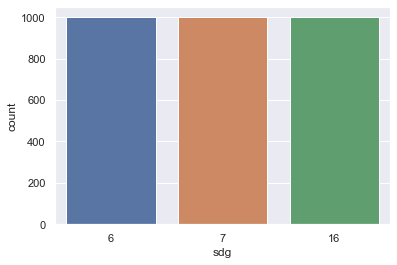

In [152]:
ax = sns.countplot(x='sdg', data=df)

Se puede evidenciar que la variable objetivo tiene el mismo número de valores en el dataframe, lo cual es una buena señal, ya que el modelo no generará ningún sesgo hacia algún etiqueta.

In [153]:
df['document_lengths'] = np.array(list(map(len, df['Textos_espanol'].str.split(' '))))

In [154]:
print("Promedio de palabras en Textos_espanol: {}.".format(np.mean(df.document_lengths)))
print("Desviación estándar de palabras en Textos_espanol: {}.".format(np.std(df.document_lengths)))
print("Mediana de palabras en Textos_espanol: {}.".format(np.median(df.document_lengths)))
print("Moda de palabras en Textos_espanol: {}.".format(pd.Series(df.document_lengths).mode()[0]))
print("Mínimo número de palabras en Textos_espanol: {}.".format(min(df.document_lengths)))
print("Máximo número de palabras en Textos_espanol: {}.".format(max(df.document_lengths)))

Promedio de palabras en Textos_espanol: 119.53733333333334.
Desviación estándar de palabras en Textos_espanol: 37.52177953609817.
Mediana de palabras en Textos_espanol: 115.0.
Moda de palabras en Textos_espanol: 114.
Mínimo número de palabras en Textos_espanol: 24.
Máximo número de palabras en Textos_espanol: 266.


In [155]:
df.document_lengths.describe()

count    3000.000000
mean      119.537333
std        37.528035
min        24.000000
25%        89.000000
50%       115.000000
75%       149.000000
max       266.000000
Name: document_lengths, dtype: float64

C:\Users\juanm\AppData\Local\Temp\ipykernel_7756\2066184362.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.document_lengths, bins=50, ax=ax)


<Axes: title={'center': 'Distribución del número de palabras'}, xlabel='document_lengths', ylabel='Density'>

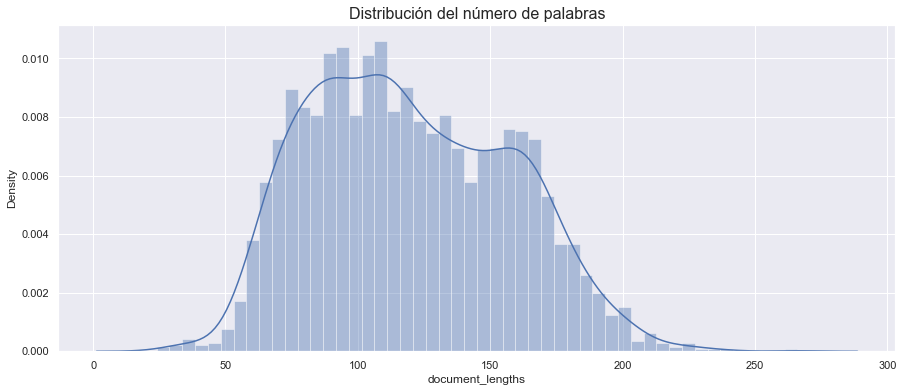

In [156]:
## Distribución del número de palabras
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribución del número de palabras", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(df.document_lengths, bins=50, ax=ax)

In [157]:
dist_per_target= pd.pivot_table(df, values='document_lengths', index=['sdg'], aggfunc={'document_lengths': [np.mean, min, max,np.std]})
dist_per_target

,max,mean,min,std
sdg,,,,
6,239,107.351,42,34.255061
7,234,107.681,35,34.098239
16,266,143.580,24,31.996615


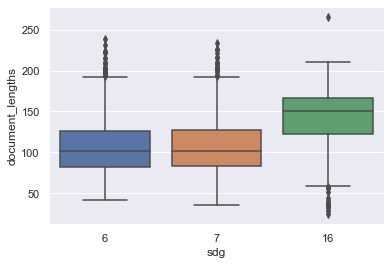

In [158]:
ax = sns.boxplot(x='sdg' , y='document_lengths' , data = df, orient = 'v')

In [159]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

## 2. Preparación de los datos

La preparacion de datos es esencial antes de alimentar un texto a un modelo de clasificacion por varias razones clave. Ayuda a normalizar el texto, eliminando caracteres innecesarios y reduciendo la dimensionalidad al quitar palabras comunes (stop words), signos de puntuacion, caracteres especiales. Esto resulta en un texto más limpio y coherente, lo que permite que el modelo se enfoque en las características más importantes, generalice mejor los datos nuevos y tome decisiones más precisas.

In [160]:
def remove_non_ascii(words):
    """Eliminar caracteres no ASCII de una lista de palabras tokenizadas. """
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convertir todos los caracteres a minúsculas en una lista de palabras tokenizadas"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Eliminar la puntuación de una lista de palabras tokenizadas."""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Reemplazar todas las ocurrencias de números en una lista de palabras tokenizadas con su representación textual."""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Eliminar las palabras de parada (stop words) de una lista de palabras tokenizadas."""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words


def preprocessing(words):
    words = to_lowercase(words)
    #words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [161]:
df['Textos_espanol'] = df['Textos_espanol'].apply(contractions.fix) 

El propósito de este código es expandir las contracciones en los datos de texto, lo que puede ayudar a mejorar la precisión de las tareas de procesamiento de lenguaje natural.

Las contracciones son versiones abreviadas de palabras o frases que se utilizan comúnmente en el habla y la escritura informales. Por ejemplo, "del" es una contracción de "de el". Expandir contracciones implica reemplazar la versión abreviada por la versión completa de la palabra o frase.

Al expandir las contracciones en los datos de texto, podemos mejorar la precisión de las tareas de procesamiento de lenguaje natural, como el análisis de sentimientos, la modelización de temas y la clasificación de texto.

In [162]:
df['words'] = df['Textos_espanol'].apply(word_tokenize).apply(preprocessing)
df.head()

,Textos_espanol,sdg,document_lengths,words
0,"Es importante destacar que, en un año de sequía, se espera que disminuyan todos los aportes, pero que aumente la demanda de agua de los cultivos y de la vegetación, lo que provocará una reducción del caudal de los ríos que están conectados hidrológicamente con el acuífero, así como una menor disponibilidad de agua para otros ecosistemas dependientes de las aguas subterráneas. Estas externalidades espaciales pueden incluir el agotamiento de los cursos de agua y el descenso del nivel freático local. Por ejemplo, el bombeo continuo del pozo B provocará el agotamiento de los cursos de agua y la reducción de su caudal.",6,103,"[importante, destacar, ano, sequia, espera, disminuyan, aportes, aumente, demanda, agua, cultivos, vegetacion, provocara, reduccion, caudal, rios, estan, conectados, hidrologicamente, acuifero, asi, menor, disponibilidad, agua, ecosistemas, dependientes, aguas, subterraneas, externalidades, espaciales, pueden, incluir, agotamiento, cursos, agua, descenso, nivel, freatico, local, ejemplo, bombeo, continuo, pozo, b, provocara, agotamiento, cursos, agua, reduccion, caudal]"
1,"Hay una gran cantidad de literatura sobre Australia en esta área que sugiere fuertemente que el comercio de agua, especialmente en los mercados a corto plazo, no solo permite mitigar sustancialmente los impactos de las sequías en la agricultura, sino que ahora los agricultores lo consideran como un medio útil y básico. instrumento en su caja de herramientas de gestión de riesgos. Los desafíos políticos para Australia en el área de la regulación del agua en la agricultura están más en las áreas de cómo ajustar el sistema existente y los problemas de solidez relacionados con el cambio climático. Si bien el ejemplo australiano ilustra las posibles ganancias de eficiencia que surgen del comercio de agua, especialmente para gestionar la escasez de agua en circunstancias de sequía, la elección de un instrumento siempre debe considerar la gama completa de costos y beneficios.",6,142,"[gran, cantidad, literatura, australia, area, sugiere, fuertemente, comercio, agua, especialmente, mercados, corto, plazo, solo, permite, mitigar, sustancialmente, impactos, sequias, agricultura, sino, ahora, agricultores, consideran, medio, util, basico, instrumento, caja, herramientas, gestion, riesgos, desafios, politicos, australia, area, regulacion, agua, agricultura, estan, mas, areas, ajustar, sistema, existente, problemas, solidez, relacionados, cambio, climatico, si, bien, ejemplo, australiano, ilustra, posibles, ganancias, eficiencia, surgen, comercio, agua, especialmente, gestionar, escasez, agua, circunstancias, sequia, eleccion, instrumento, siempre, debe, considerar, gama, completa, costos, beneficios]"
2,"Los procesos de descentralización, emprendidos para una serie de actividades que antes realizaba el gobierno central, llevaron a modificaciones importantes en la forma en que se administraba y operaba el sector del agua. Las únicas excepciones a esta tendencia fueron Azerbaiyán, Bielorrusia y Turkmenistán, donde la gestión del sector del agua ha permanecido fuertemente centralizada. En Azerbaiyán, por ejemplo, la empresa nacional AZERSU JSC suministra agua al 65 % de la población, con un 10 % proporcionado por pequeños operadores privados y un 25 % por los propios hogares.",6,89,"[procesos, descentralizacion, emprendidos, serie, actividades, realizaba, gobierno, central, llevaron, modificaciones, importantes, forma, administraba, operaba, sector, agua, unicas, excepciones, tendencia, azerbaiyan, bielorrusia, turkmenistan, gestion, sector, agua, permanecido, fuertemente, centralizada, azerbaiyan, ejemplo, empresa, nacional, azersu, jsc, suministra, agua, 65, poblacion, 10, proporcionado, pequenos, operadores, privados, 25, propios, hogares]"
3,"Esto puede tener consecuencias sustanciales para la calidad del agua, especialmente en el río Mississippi y el norte del Golfo de México (De la Torre Ugarte et al., 

In [163]:
wordnet_lem = WordNetLemmatizer()

El "stemming" es una técnica utilizada para reducir una palabra inflexionada a su raíz o lexema. Por ejemplo, las palabras "programación", "programador" y "programas" pueden reducirse todas a la raíz común "programa". En otras palabras, "programa" puede ser utilizado como sinónimo de las tres palabras inflexionadas anteriores.

La "lematización" es otra técnica utilizada para reducir las palabras inflexionadas a su forma raíz. Describe el proceso algorítmico de identificar el "lema" (forma de diccionario) de una palabra inflexionada basado en su significado previsto.

In [164]:
df['words'] = df['words'].apply( lambda lst:[wordnet_lem.lemmatize(word) for word in lst])

In [165]:
df.sample(3)

,Textos_espanol,sdg,document_lengths,words
2308,"Los estudiosos de las relaciones internacionales han prestado muy poca atención al tema de por qué y cuándo los estados ingresan a las organizaciones internacionales (OI). Argumentamos que los estados tienen una razón particular para ingresar a las OI durante el proceso de democratización. En medio de una transición democrática, los líderes estatales tienen dificultades para asumir un compromiso creíble de sostener las reformas, ya que pueden beneficiarse de la reversión de la liberalización. Ganar membresía en una IO puede mejorar la credibilidad de los compromisos de los líderes con las reformas democráticas. Sin embargo, no todas las OI son igualmente útiles en este sentido. Distinguimos entre las OI que cubren estándares en áreas como los derechos humanos y la protección del medio ambiente, las que regulan la actividad económica y las que son foros para abordar problemas políticos amplios. Argumentamos que los estados en proceso de democratización tienen más razones para unirse a OI económicas y basadas en estándares que a organizaciones políticas. Los resultados de un conjunto de pruebas estadísticas respaldan este argumento.",16,175,"[estudiosos, relaciones, internacionales, prestado, poca, atencion, tema, ingresan, organizaciones, internacionales, oi, argumentamos, razon, particular, ingresar, oi, proceso, democratizacion, medio, transicion, democratica, lideres, estatales, dificultades, asumir, compromiso, creible, sostener, reformas, pueden, beneficiarse, reversion, liberalizacion, ganar, membresia, io, puede, mejorar, credibilidad, compromisos, lideres, reformas, democraticas, embargo, toda, oi, igualmente, utiles, distinguimos, oi, cubren, estandares, area, derechos, humanos, proteccion, medio, ambiente, regulan, actividad, economica, foros, abordar, problemas, politico, amplios, argumentamos, proceso, democratizacion, ma, razones, unirse, oi, economicas, basadas, estandares, organizaciones, politicas, resultados, conjunto, pruebas, estadisticas, respaldan, argumento]"
1278,"Los diez proyectos seleccionados se beneficiarán de la emisión simplificada de permisos y la posibilidad de incentivos regulatorios, asignación de costos transfronterizos y financiamiento bajo el Instrumento de Asistencia Pre-Adhesión de la Unión Europea (UE) y el Mecanismo de Inversión en la Vecindad. Además, se han aprobado dos proyectos de electricidad y ocho de gas como Proyectos de Interés Mutuo con la UE. Requerirá una voluntad política e institucional sostenida para que las economías logren objetivos compartidos tanto a nivel nacional como regional mediante la implementación de los marcos legislativos y regulatorios adoptados. En la actualidad, el cumplimiento del Tercer Paquete de Energía de la UE es, en el mejor de los casos, irregular, pero es un requisito previo esencial para la interoperabilidad de los sistemas energéticos de la SEE y la UE, así como para mejorar la productividad y la competitividad del sector a nivel regional y nacional.",7,149,"[diez, proyectos, seleccionados, beneficiaran, emision, simplificada, permisos, posibilidad, incentivos, regulatorios, asignacion, costos, transfronterizos, financiamiento, bajo, instrumento, asistencia, preadhesion, union, europea, ue, mecanismo, inversion, vecindad, ademas, aprobado, do, proyectos, electricidad, ocho, gas, proyectos, interes, mutuo, ue, requerira, voluntad, politica, institucional, sostenida, economias, logren, objetivos, compartidos, nivel, nacional, regional, mediante, implementacion, marcos, legislativos, regulatorios, adoptados, actualidad, cumplimiento, tercer, paquete, energia, ue, mejor, casos, irregular, requisito, previo, esencial, interoperabilidad, sistemas, energeticos, see, ue, asi, mejorar, productividad, competitividad, sector, nivel, regional, nacional]"
2205,"El artículo explora el gobierno electrónico como una iniciativa de intervención de cambio en la administración pública del estado de Sabah. Discute su 

In [166]:
df['words'] = df['words'].apply(lambda x: ' '.join(map(str, x)))
df.sample(1)

,Textos_espanol,sdg,document_lengths,words
2143,"En los últimos años, los Estados del Consejo de Cooperación del Golfo (CCG) se han mostrado cada vez más dispuestos a ratificar los instrumentos de derechos humanos de las Naciones Unidas. Este artículo examina los motivos subyacentes de estas ratificaciones y el alcance limitado y los impulsores de las reformas nacionales posteriores a la ratificación. Basándose tanto en un análisis cuantitativo de la participación en los órganos de tratados de la ONU y los mecanismos basados en la Carta en más de 120 informes de la ONU, como en entrevistas cualitativas con más de sesenta y cinco funcionarios gubernamentales, miembros de la sociedad civil, Instituciones Nacionales de Derechos Humanos, abogados y jueces de los seis Estados, este artículo sostiene que en los Estados del CCG la ratificación de los tratados de derechos humanos de la ONU obedece a un deseo de mejorar la posición en la comunidad internacional. La ratificación de tratados tiene efectos limitados impulsados por la socialización internacional y las preferencias cautelosas de los dirigentes.",16,167,ultimos ano consejo cooperacion golfo ccg mostrado cada vez ma dispuestos ratificar instrumentos derechos humanos naciones unidas articulo examina motivos subyacentes ratificaciones alcance limitado impulsores reformas nacionales posteriores ratificacion basandose analisis cuantitativo participacion organos tratados onu mecanismos basados carta ma 120 informes onu entrevistas cualitativas ma sesenta cinco funcionarios gubernamentales miembros sociedad civil instituciones nacionales derechos humanos abogados jueces seis articulo sostiene ccg ratificacion tratados derechos humanos onu obedece deseo mejorar posicion comunidad internacional ratificacion tratados efectos limitados impulsados socializacion internacional preferencias cautelosas dirigentes


## 3. Construcción de Modelos

La división del conjunto de datos en conjuntos de entrenamiento y prueba es un paso importante en el aprendizaje automático, ya que nos permite evaluar el rendimiento del modelo resultante en datos nuevos y no vistos. El propósito de estratificar los datos en la división de entrenamiento y prueba es garantizar que la proporción de las clases de la variable objetivo sea la misma en ambos conjuntos. Esto es importante porque si el conjunto de entrenamiento tiene una proporción significativamente diferente de las clases de la variable objetivo en comparación con el conjunto de prueba, es posible que el modelo resultante no se generalice bien a nuevos datos.

Por ejemplo, si la variable objetivo es binaria (por ejemplo, 0 o 1) y el conjunto de entrenamiento tiene una proporción mucho más alta de 1 en comparación con el conjunto de prueba, es posible que el modelo resultante esté sesgado hacia predecir 1 y tenga un mal rendimiento en nuevos datos con una proporción más equilibrada de 0 y 1.

Al estratificar los datos, nos aseguramos de que los conjuntos de entrenamiento y prueba tengan una proporción similar de las clases de la variable objetivo, lo que puede ayudar a mejorar el rendimiento de generalización del modelo resultante.

In [167]:
X_train, X_test, y_train, y_test = train_test_split(df["words"], df["sdg"], test_size=0.3, stratify=df["sdg"], random_state=1)

In [168]:
X_train.shape, X_test.shape

((2100,), (900,))

Un problema fundamental en procesamiento de lenguaje natural es construir una representación numérica de las palabras. La vectorización es el proceso de convertir una palabra en un vector de números que incorpora la información contenida en la palabra. Dependiendo de la técnica de vectorización, este vector puede tener propiedades adicionales que permiten la comparación con otras palabras.
En nuestro modelo, probaremos Count-based vectorization y TF-IDF.

## Modelo 1 Count-based vectorization


Cada palabra única que aparece en el corpus se le asigna una columna en el vocabulario. Cada documento, que correspondería a mensajes individuales en el ejemplo del spam, se le asigna una fila. Las cuentas de las palabras que aparecen en ese documento se ingresan en la celda correspondiente al documento y a la palabra. Terminamos con una matriz n x m, donde n es el número de documentos y m es el tamaño del vocabulario, y cada celda contiene la cuenta de las palabras en ese documento.

In [169]:
bow = CountVectorizer(analyzer='word', stop_words=stop_words, lowercase=True)

In [170]:
X_bow = bow.fit_transform(X_train)#X_train["words"])

In [171]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 17665


In [172]:
bow_model = RandomForestClassifier(random_state=2)

In [173]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

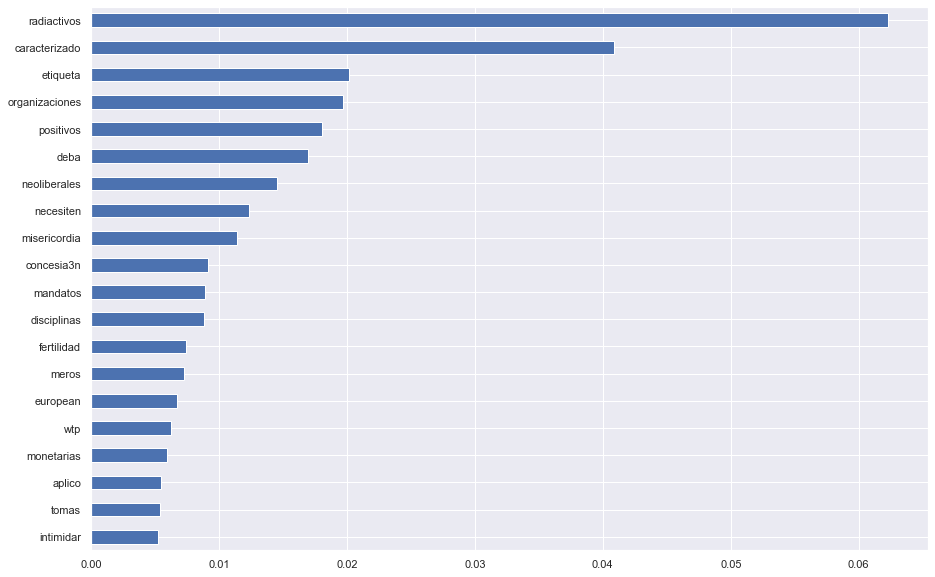

In [174]:
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [175]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 99.81


In [176]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test))

### Evaluacion modelo 1 

El puntaje de precisión es una medida de la capacidad de un modelo para identificar correctamente las predicciones positivas. Se calcula como la razón de verdaderos positivos sobre la suma de verdaderos positivos y falsos positivos. Un puntaje de precisión alto indica que el modelo puede identificar correctamente la mayoría de las predicciones positivas.

El puntaje de recall es una medida de la capacidad de un modelo para identificar correctamente muestras positivas. Se calcula como la razón de verdaderos positivos sobre la suma de verdaderos positivos y falsos negativos. Un puntaje de recall alto indica que el modelo puede identificar correctamente la mayoría de las muestras positivas.

El puntaje F1 es una medida de precisión de un modelo que tiene en cuenta tanto la precisión como el recall. Se calcula como la media armónica de la precisión y el recall. Un puntaje F1 alto indica que el modelo puede identificar correctamente la mayoría de las muestras positivas minimizando los falsos positivos.

El argumento 'average' especifica el tipo de promedio realizado en los datos. En este caso, se utiliza el promedio 'micro', que calcula el puntaje de recall de manera global contando los verdaderos positivos totales, los falsos negativos y los falsos positivos.

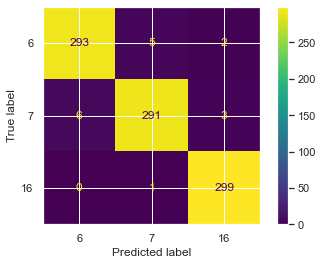

In [177]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [178]:
print("Precision Score : ",precision_score(y_train, y_train_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_train, y_train_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("F1:", f1_score(y_train, y_train_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  1.0
Recall Score :  1.0
F1: 1.0


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [179]:
print("Precision Score : ",precision_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("F1:", f1_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9811111111111112
Recall Score :  0.9811111111111112
F1: 0.9811111111111112


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


El modelo que utiliza la técnica de Bolsa de Palabras (BoW) junto con un clasificador Random Forest ha arrojado resultados muy sólidos en las métricas de precisión, recall y F1-score, con puntajes cercanos a 0.981. Estos puntajes indican que el modelo es altamente preciso en la identificación de predicciones positivas y tiene una excelente capacidad para detectar correctamente muestras positivas.

## Modelo 2 Multinomial Naive Bayes

Naive Bayes Multinomial es un clasificador probabilístico que se basa en el teorema de Bayes para realizar predicciones de clasificación. Funciona asumiendo independencia condicional entre las características y calcula las probabilidades de pertenencia a una clase en función de la frecuencia de las características en los datos. Se utiliza principalmente en tareas de clasificación de texto, como análisis de sentimientos, clasificación de documentos y detección de spam, donde la frecuencia de palabras o características desempeña un papel importante en la toma de decisiones.

In [180]:
vect= CountVectorizer(analyzer='word', stop_words=stop_words, lowercase=True)

In [181]:
x_train_vect = vect.fit_transform(X_train)
x_test_vect = vect.transform(X_test)

In [182]:
cb= MultinomialNB()

In [183]:
cb.fit(x_train_vect, y_train)

MultinomialNB()

In [184]:
y_train_cb_predict = cb.predict(x_train_vect)

In [185]:
y_test_cb_predict = cb.predict(vect.transform(X_test))

<Axes: >

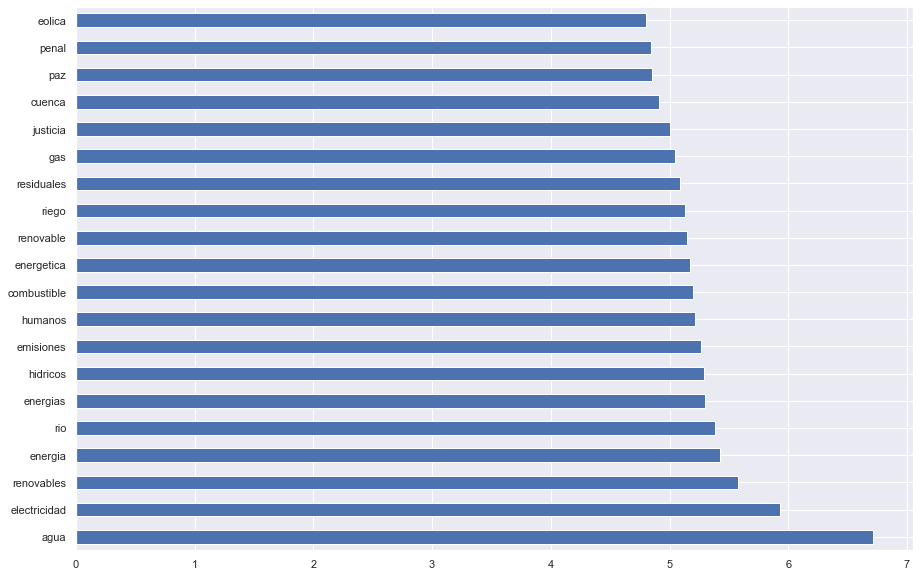

In [186]:
feature_log_prob = cb.feature_log_prob_
word_probabilities = pd.DataFrame(data=feature_log_prob, columns=vect.get_feature_names_out(), index=cb.classes_)
word_probabilities = word_probabilities.T
word_probabilities['Class_Difference'] = word_probabilities.max(axis=1) - word_probabilities.min(axis=1)
top_words = word_probabilities.sort_values(by='Class_Difference', ascending=False).head(20)
top_words['Class_Difference'].plot.barh(figsize=(15, 10))

### Evaluacion modelo 2

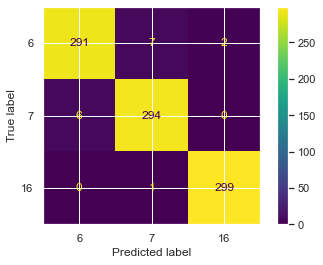

In [187]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_cb_predict)

In [188]:

print("Precision Score : ",precision_score(y_test, y_test_cb_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_cb_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("F1:", f1_score(y_test, y_test_cb_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9822222222222222
Recall Score :  0.9822222222222222
F1: 0.9822222222222222


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


El modelo que utiliza el vectorizador de conteo (CountVectorizer) junto con el clasificador Multinomial Naive Bayes ha arrojado resultados sólidos en las métricas de precisión, recall y F1-score, con puntajes cercanos a 0.982

## Modelo 3 TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF asigna valores ponderados a las palabras en un documento, lo que permite representar la importancia relativa de las palabras en función de su frecuencia y rareza en el contexto de toda la colección de documentos. Esta representación se utiliza ampliamente en tareas de minería de texto, recuperación de información, clasificación de documentos y análisis de sentimientos, entre otros.

In [189]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [190]:
X_tfid = tfidf.fit_transform(X_train)

C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [191]:
tf_idf_model = RandomForestClassifier(random_state=3)

In [192]:
tf_idf_model.fit(X_tfid, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

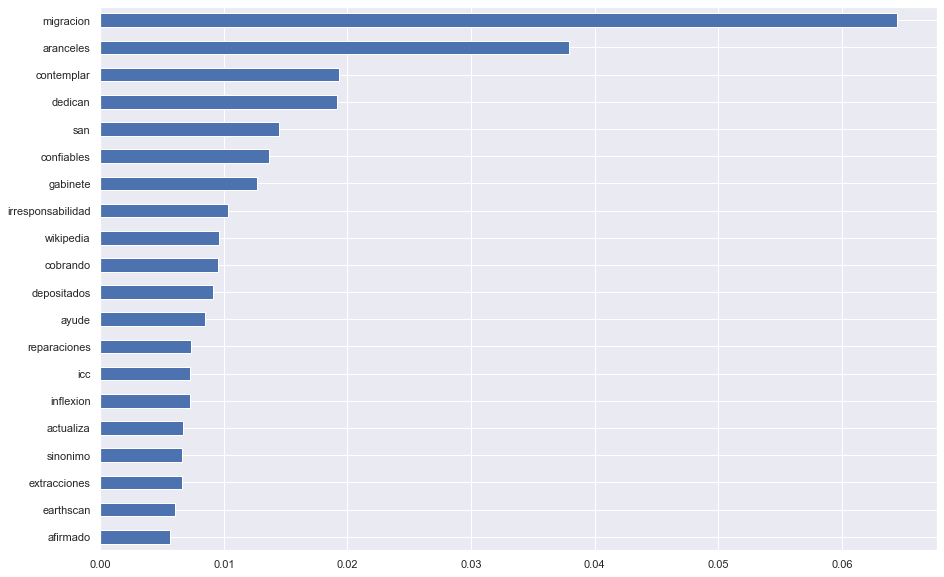

In [193]:
pd.Series(tf_idf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [194]:
y_train_tfidf_predict = tf_idf_model.predict(X_tfid)
y_test_tfidf_predict = tf_idf_model.predict(tfidf.transform(X_test))

### Evaluacion modelo 3

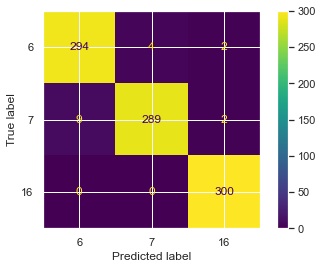

In [195]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [196]:
print("Precision Score : ",precision_score(y_test, y_test_tfidf_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_tfidf_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("F1:", f1_score(y_test, y_test_tfidf_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9811111111111112
Recall Score :  0.9811111111111112
F1: 0.9811111111111112


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


El modelo que utiliza la técnica de TF-IDF (Term Frequency-Inverse Document Frequency) junto con un clasificador Random Forest ha producido resultados muy sólidos en las métricas de precisión, recall y F1-score, con puntajes cercanos a 0.981. En general, estos resultados respaldan la eficacia de este modelo en la tarea de clasificación de datos utilizando la representación ponderada de TF-IDF. 

## Modelo 4 RandomizedSearchCV


La clase RandomizedSearchCV se utiliza para realizar una búsqueda aleatoria en un espacio de hiperparámetros dado para un conjunto de técnicas de aprendizaje automático.

El objeto RandomizedSearchCV toma varios argumentos. El primer argumento, pipeline, es el conjunto de técnicas de aprendizaje automático que se optimizará. El segundo argumento, param_grid, es un diccionario de hiperparámetros y sus valores correspondientes que se buscarán. El argumento n_iter especifica la cantidad de configuraciones de parámetros que se muestrearán. En este caso, se muestrearán 10 configuraciones de parámetros.

El argumento scoring es una lista de métricas de puntuación que se utilizarán para evaluar el rendimiento del conjunto de técnicas de aprendizaje automático. En este caso, se utilizarán la precisión, el recall y la puntuación F1. El argumento refit especifica qué métrica se utilizará para elegir los mejores parámetros. En este caso, se utilizará la puntuación F1.

El argumento cv especifica la cantidad de divisiones para la validación cruzada. En este caso, se utilizará una validación cruzada de 10 divisiones. El argumento return_train_score especifica si se devolverán las puntuaciones de entrenamiento además de las puntuaciones de prueba. El argumento verbose especifica el nivel de detalle en la salida, con un valor más alto que resulta en más información. Por último, el argumento random_state establece la semilla del generador de números aleatorios, lo que garantiza que se obtengan los mismos resultados cada vez que se ejecute el código.

El objeto RandomizedSearchCV resultante se puede utilizar para ajustar el conjunto de técnicas de aprendizaje automático a los datos y buscar en el espacio de hiperparámetros la mejor combinación de hiperparámetros que optimice la métrica elegida.



In [197]:
pipeline = Pipeline(steps = [
    ("vectorizer", CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)),
    ("classifier", RandomForestClassifier(random_state=4))
])

In [198]:
param_grid = {
    "vectorizer": [CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words), TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words)],
    "vectorizer__lowercase": [True, False],
    "classifier__n_estimators": [50, 100],
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [25, 50, 75, 100]
}

In [199]:
search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring=["precision", "recall", "f1"], refit="f1", cv=10, return_train_score=True, verbose=1, random_state=5)

In [200]:
search.fit(X_train, y_train)

C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py", line 2127, in precision_score
    p, _, _, _ = precision_recall_fscore_support(
  File "C:\Users\juanm\AppData\Roaming\Python\Python39\

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('vectorizer',
                                              CountVectorizer(stop_words=['de',
                                                                          'la',
                                                                          'que',
                                                                          'el',
                                                                          'en',
                                                                          'y',
                                                                          'a',
                                                                          'los',
                                                                          'del',
                                                                          'se',
                                                                          'las',
                                                                          'por',
                                                                          'un',
                                                                          'para',
                                                                          'con',
                                                                          'no',
                                                                          'una',
                                                                          'su',
                                                                          'al',
                                                                          'lo',
                                                                          'como',
                                                                          'más',
                                                                          'pero',
                                                                          'sus',
                                                                          'le',
                                                                          'ya',
                                                                          'o',
                                                                          'este',
                                                                          'sí',
                                                                          'porque', ...],
                                                              tokenizer=<function word_tokenize at 0x00000290F09989D0>)),
                                             ('classifier',
                                              RandomForestCl...
                                                                                   'que',
                                                                                   'el',
                                                                                   'en',
                                                                                   'y',
                                                                                   'a',
                                                                                   'los',
                                                                                   'del',
                                                                                   'se',
                                                                                   'las',
                                                                                   'por',
                                                                                   'un',
                                                                                   'para',
                                                                                   'con',
                                                                                 

In [201]:
search.best_params_

{'vectorizer__lowercase': False,
 'vectorizer': CountVectorizer(lowercase=False,
                 stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                             'del', 'se', 'las', 'por', 'un', 'para', 'con',
                             'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                             'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                             'porque', ...],
                 tokenizer=<function word_tokenize at 0x00000290F09989D0>),
 'classifier__n_estimators': 100,
 'classifier__max_depth': 100,
 'classifier__criterion': 'gini'}

In [202]:
y_train_search_predict = search.best_estimator_.predict(X_train)
y_test_search_predict = search.best_estimator_.predict(X_test)

### Evaluacion modelo 4

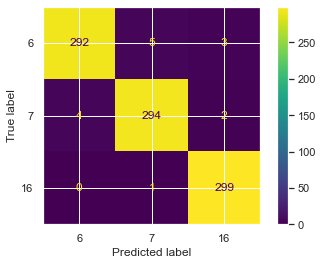

In [203]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_search_predict)

In [204]:
print("Precision Score : ",precision_score(y_test, y_test_search_predict, 
                                           pos_label='positive',
                                           average='weighted'))
print("Recall Score : ",recall_score(y_test, y_test_search_predict, 
                                           pos_label='positive',
                                           average='weighted'))
print("F1:", f1_score(y_test, y_test_search_predict, 
                                           pos_label='positive',
                                           average='weighted'))

Precision Score :  0.983346372688478
Recall Score :  0.9833333333333333
F1: 0.9833106656592145


C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\juanm\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(



Los resultados de precisión (Precision Score), recall (Recall Score) y puntuación F1 (F1) indican que el modelo que utiliza CountVectorizer en combinación con el clasificador RandomForestClassifier ha demostrado un rendimiento sólido en la tarea de clasificación. Con puntajes cercanos a 0.983 en todas estas métricas, el modelo es altamente preciso en la identificación de predicciones positivas y muestra una excelente capacidad para detectar correctamente muestras positivas.

Estos resultados sugieren que el modelo es efectivo y confiable en la tarea para la que ha sido diseñado. La combinación de CountVectorizer para la representación de texto y el clasificador RandomForestClassifier ha demostrado ser exitosa en la clasificación de datos. 

##  Exportación del mejor modelo

In [205]:
#export best model
dump(search.best_estimator_, 'pipe.joblib')

['pipe.joblib']

## Generar predicciones

In [3]:
pipeline_loaded = load('pipe.joblib')

In [4]:
df_new = pd.read_excel("data/SinEtiquetatest_cat_6716.xlsx")


In [8]:
depuerba = pd.read_csv("test_como_queda.csv")

In [9]:
depuerba['sdg'] = pipeline_loaded.predict(depuerba["Textos_espanol"])

In [11]:
depuerba.sample(2)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [7]:
df_new.to_csv("data/ConEtiquetatest_cat_6716.csv", sep=",", index=False, encoding='utf-8')